In [2]:
import pandas as pd

df = pd.read_csv("python_task_dataset.csv")
df.head()

,device_id,device_type,datetime,ev_type,adv_type,region_id,age,gender
0,100001,android,2019-03-01 15:58:02,0,multi,2,14,2
1,100001,android,2019-03-01 17:13:53,0,multi,2,14,2
2,100002,android,2019-03-01 23:13:25,0,multi,2,0,0
3,100002,android,2019-03-01 23:25:06,0,multi,2,0,0
4,100003,android,2019-03-01 15:27:53,0,multi,1,0,0


<Axes: xlabel='region_id'>

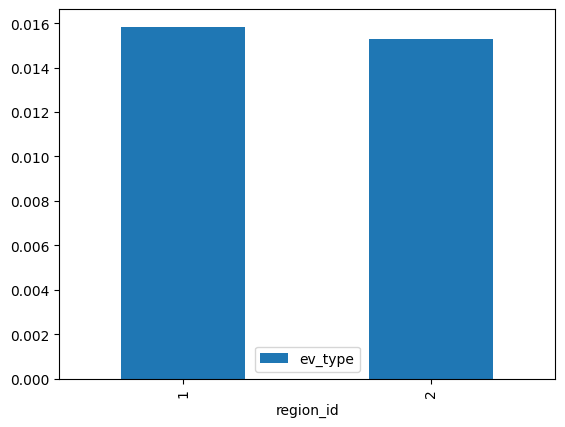

In [2]:
def t(r: pd.Series):
    res_1 = 0
    res_0 = 0
    for x in r:
        if x==1:
            res_1 += 1
            continue
        res_0 += 1
    return res_1/res_0

df.groupby("region_id").agg({"ev_type": t, "region_id": "min"}).plot(x="region_id", kind="bar")

При изучении данных было обнаруженно, что один и тот же device_id имеет несколько вариаций age

In [3]:
df.groupby("device_id").agg({"age": lambda x: x.nunique()}).sort_values("age", ascending=False).head(30)

,age
device_id,
100288,26
152972,4
142811,3
118633,3
147626,3
115856,3
104594,3
161390,3
166303,3


Например есть пользователи помолодевшие за день на 42 года

In [4]:
df.loc[df.device_id == 158188]

,device_id,device_type,datetime,ev_type,adv_type,region_id,age,gender
110670,158188,ios,2019-03-06 20:12:24,0,video,1,33,1
110671,158188,ios,2019-03-05 23:59:46,0,video,1,75,1
110672,158188,ios,2019-03-07 09:23:48,0,video,1,33,1


Для начала можно увидеть что отношение кликов у пользователей android выше

<Axes: xlabel='device_type'>

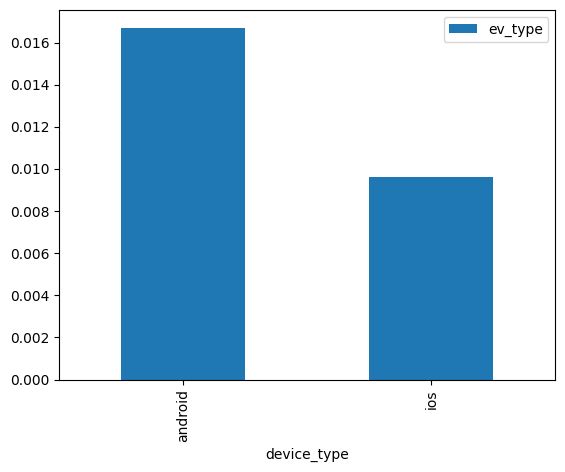

In [5]:
df.groupby(["device_type"]).agg({"ev_type": t, "device_type": "min"}).plot(x="device_type", kind="bar")

Видео являются более эффективными

<Axes: xlabel='adv_type'>

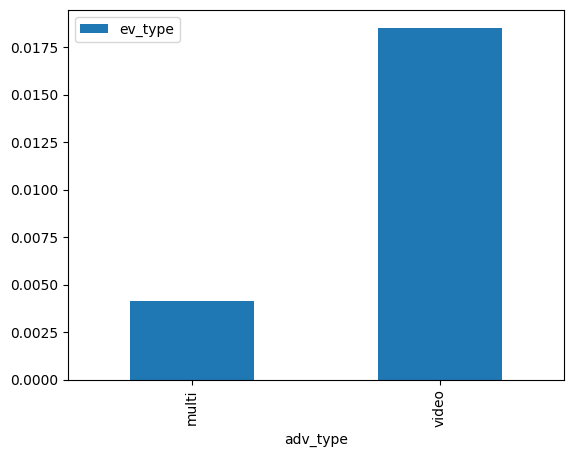

In [6]:
df.groupby(["adv_type"]).agg({"ev_type": t, "adv_type": "min"}).plot(x="adv_type", kind="bar")

Так же заметно различие в разрезе пола, женщины реагируют гораздо чаще

In [7]:
df.groupby(["gender"]).agg({"ev_type": t})

,ev_type
gender,
0,0.004607
1,0.017708
2,0.003364


In [8]:
df["day_of_weak"] = pd.to_datetime(df['datetime']).dt.dayofweek

Построив график можно сказать, что показатель растет к четвергу, а потом начинает падать.

<Axes: xlabel='day_of_weak'>

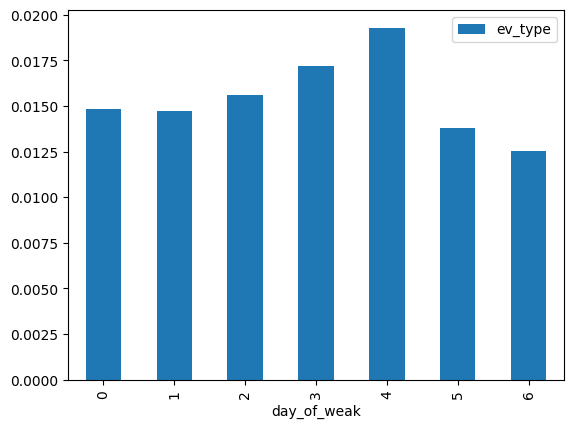

In [9]:
df.groupby(["day_of_weak"]).agg({"ev_type": t, "day_of_weak": "min"}).plot(x="day_of_weak", kind="bar")

In [10]:
df["hours"] = pd.to_datetime(df.datetime).dt.hour

<Axes: xlabel='hours'>

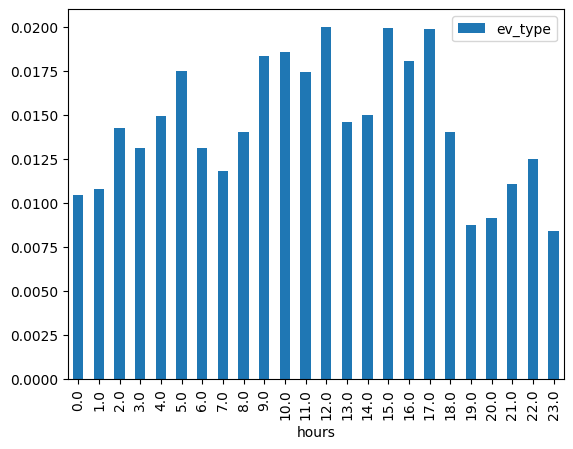

In [11]:
df.groupby(["hours"]).agg({"ev_type": t, "hours": "mean"}).plot(x="hours", kind="bar")

In [3]:
df.head()

,device_id,device_type,datetime,ev_type,adv_type,region_id,age,gender
0,100001,android,2019-03-01 15:58:02,0,multi,2,14,2
1,100001,android,2019-03-01 17:13:53,0,multi,2,14,2
2,100002,android,2019-03-01 23:13:25,0,multi,2,0,0
3,100002,android,2019-03-01 23:25:06,0,multi,2,0,0
4,100003,android,2019-03-01 15:27:53,0,multi,1,0,0


In [12]:
train_data = df[["device_type", 'ev_type', 'adv_type', "region_id", 'age', "gender", "day_of_weak", "hours"]]

data_x = train_data.drop(columns=["ev_type"])
data_y = train_data.ev_type


In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (OneHotEncoder(), ["device_type", "adv_type", "region_id", "gender"]),
    remainder="passthrough"
)


transformer.fit(data_x)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['device_type', 'adv_type', 'region_id',
                                  'gender'])])

In [14]:
def transform_preproc(data, transformer):
    res = transformer.transform(data)
    res = pd.DataFrame(
        res,
        columns=transformer.get_feature_names_out()
    )
    return res

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

train_x, test_x, train_y , test_y = train_test_split(transform_preproc(data_x, transformer), data_y, train_size=0.2)

In [16]:
from sklearn.model_selection import GridSearchCV

params = {
    'criterion':  ['gini', 'entropy'],
    'max_depth':  [None, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'splitter': ['best', 'random']
}

clf = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=5,
    n_jobs=5,
    verbose=1,
)

clf.fit(transform_preproc(data_x, transformer), data_y)
print(clf.best_params_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
{'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'splitter': 'best'}


[Text(0.5, 0.8333333333333334, 'onehotencoder__adv_type_video <= 0.5\ngini = 0.03\nsamples = 265403\nvalue = [261295, 4108]'),
 Text(0.25, 0.5, 'remainder__age <= 10.5\ngini = 0.008\nsamples = 51410\nvalue = [51199, 211]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.009\nsamples = 37772\nvalue = [37597, 175]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.005\nsamples = 13638\nvalue = [13602, 36]'),
 Text(0.75, 0.5, 'onehotencoder__device_type_android <= 0.5\ngini = 0.036\nsamples = 213993\nvalue = [210096, 3897]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.019\nsamples = 36808\nvalue = [36457, 351]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.039\nsamples = 177185\nvalue = [173639, 3546]')]

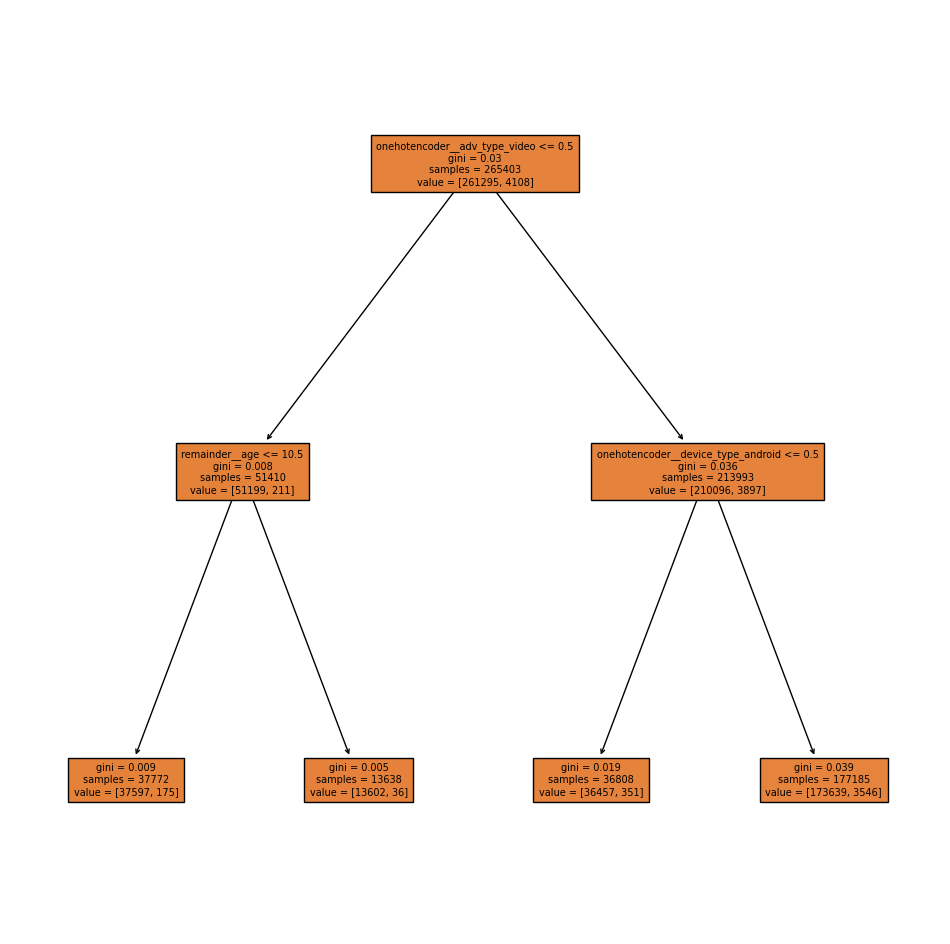

In [17]:
from sklearn import tree
from matplotlib import pyplot as plt
plt.figure(figsize=(12,12))
tree.plot_tree(clf.best_estimator_,
               feature_names=train_x.columns.to_list(),
               filled=True,
               fontsize=7)

In [18]:
3546 / 173639

0.02042167946141132

рекомендации:
-- показывать больше видео рекламы
-- показывать больше пользователям андроид
-- лучше не показывать рекламу пользователям, у которых не указан возраст

Самый большой показатель отношения кликов к показам у людей, которым показали видео и у них android

по дням недели нет существенных выбросов и различий
в рамках дня так же распределены клики почти равномерно